In [274]:
# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras.layers import Dense, Layer, Lambda, Multiply, Add

# Commonly used modules
import numpy as np
import os
import sys
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats.distributions import chi2
import scipy
from sklearn.metrics import confusion_matrix
import itertools as it

# Images, plots, display, and visualization
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn 

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

In [2]:
# df1 = pd.read_csv("https://raw.githubusercontent.com/VivaswatS/selCoefEst/main/traindata/trip-2021-07-28.csv")
df1 = pd.read_csv("~/selCoefEst/traindata/trip-2021-10-20.csv")

In [4]:
dat = df1.to_numpy()
gamma = np.unique(dat[:,1])
# idx = [np.where(dat[:,1] == gamma[i]) for i in np.arange(len(gamma))]

In [5]:
## read-in saved model (no retraining required)
prob_model = tf.keras.models.load_model('saved_model/lognorm_model', compile=False)
negloglik = lambda y, p_y: -tf.reduce_sum(p_y.log_prob(y))
# compile the loaded model with the custome objects
prob_model.compile(optimizer='adam', loss=negloglik)

2021-11-08 09:03:08.046805: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-08 09:03:08.476565: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [6]:
gamma

array([-1.000000e+02, -6.812921e+01, -4.641589e+01, -3.162278e+01,
       -2.154435e+01, -1.467799e+01, -1.000000e+01, -6.812921e+00,
       -4.641589e+00, -3.162278e+00, -2.154435e+00, -1.467799e+00,
       -1.000000e+00, -6.812921e-01, -4.641589e-01, -3.162278e-01,
       -2.154435e-01, -1.467799e-01, -1.000000e-01, -6.812921e-02,
       -4.641589e-02, -3.162278e-02, -2.154435e-02, -1.467799e-02,
       -1.000000e-02])

In [402]:
## picking a choice of g1 and g2 & creating a new data frame
trueg1 = -0.01
trueg2 = -10.
# 2000 x 3 (first 1000 is g1, second 1000 is g2)
newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==trueg1)),0:3].append(df1.iloc[np.ravel(np.where(dat[:,1]==trueg2)),0:3])
# newdf1 = newdf1.sample(frac=1)
newdat = newdf1.to_numpy()

In [403]:
newdat

array([[ 2.10e-03, -1.00e-02,  8.00e+00],
       [ 7.70e-03, -1.00e-02,  9.02e+02],
       [ 1.20e-03, -1.00e-02,  1.80e+01],
       ...,
       [ 1.05e-02, -1.00e+01,  8.01e+02],
       [ 5.30e-03, -1.00e+01,  3.72e+02],
       [ 5.00e-04, -1.00e+01,  5.00e+00]])

In [11]:
# log P(Xl | gamma)
def get_lp_xl(g, Xlred, N=2500):
    """function to compute L(gamma|Xl), where gamma is a range of values and Xl is a given set of freqs"""
    res = np.empty(len(Xlred))
    ub = np.exp(2.*g)*scipy.special.expi(-2.*g*0.25/N) - scipy.special.expi(2.*g*(1-0.25/N)) - np.exp(2.*g)*(np.log(0.25/N) - np.log(1-0.25/N))
    #scipy.special.expi(-g*0.25/N) - np.exp(-g)*scipy.special.expi(g*(1-0.25/N)) - np.log(0.25/N) + np.log(1-0.25/N)
    lb = np.exp(2.*g)*scipy.special.expi(2.*g*(0.25/N-1)) - scipy.special.expi(2.*g*0.25/N) - np.exp(2.*g)*(np.log(1-0.25/N) - np.log(0.25/N))
    #scipy.special.expi(g*(0.25/N-1)) - np.exp(-g)*scipy.special.expi(g*0.25/N) - np.log(1-0.25/N) + np.log(0.25/N)
    scalfact = (ub - lb)/np.expm1(2.*g)
    # return a vector...
    for ix, x in enumerate(Xlred):
        res[ix] = (1-np.exp(-2*g*(1-x)))/(x*(1-x)*(1-np.exp(-2*g)))
        #np.exp(2.*g)*scipy.special.expi(2.*g*(x-1)) - scipy.special.expi(2.*g*x) - np.exp(2.*g)*(np.log(1-x) - np.log(x))
        #-np.log(x) - np.log(1.-x) + np.log((1.-np.exp(-2.*g*(1.-x)))/(1.-np.exp(-2.*g))) / scalfact
    #res = np.sum(-np.log(xl) - np.log(1.-xl) + np.log((1.-np.exp(-2.*g*(1.-xl)))/(1.-np.exp(-2.*g)))) / scalfact
    return np.log(res/scalfact)

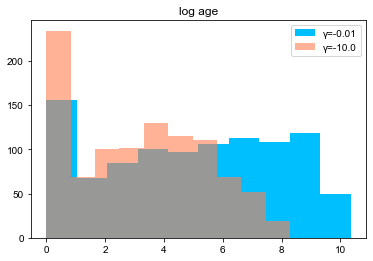

In [404]:
# plt.hist(np.log(newdat[0:1000,2]),color='deepskyblue',label='γ=-0.1')
# plt.title('log allele age')
# plt.hist(np.log(newdat[1000:2000,2]),alpha=0.6,color='coral',label='γ=-100.')
# plt.legend()
plt.hist(np.log(newdat[0:1000,2]),color='deepskyblue',label='γ={}'.format(trueg1))
plt.title('log age')
plt.hist(np.log(newdat[1000:2000,2]),alpha=0.6,color='coral',label='γ={}'.format(trueg2))
plt.legend()

In [28]:
# log P(Xl, al | gamma)
def get_lp_alxl(g, Xlred, logalred, prob_model=prob_model):
    """function to compute L(gamma|Xl,al), where gamma is a range of values and Xl & al are given sets of freqs and ages"""

    res = np.empty(len(logalred))

    ahat = prob_model(np.vstack((np.log(Xlred),np.repeat(g,len(Xlred)))).T)
    preds = ahat.mean().numpy()
    preds_sd = ahat.stddev().numpy()

    for ia, a in enumerate(logalred):
        res[ia] = scipy.stats.norm.logpdf(a, loc=preds[ia], scale=preds_sd[ia]) 
    return res

### Goal: investigate working of `get_lp_alxl` function
Below, I will use these disparate data (coming from two vastily different gammas, see hist above) and see whether there is a higher likelihood for $\gamma=-0.1$ (as compared to $\gamma=-100.0$) when I use ages above $e^6$, because alleles strongly selected against should not live for very long. 

In [171]:
# prob_model()

1534

In [174]:
# res = np.empty(len(newdat[np.where(np.log(newdat[:,2])<6)[0],0]))
res = np.empty(2000)
# ahat = prob_model(np.vstack((np.log(newdat[np.where(np.log(newdat[:,2])<6)[0],0]),np.repeat(trueg1,len(res)))).T)
ahat = prob_model(np.vstack((np.log(newdat[:,0]),np.repeat(trueg1,len(res)))).T)
preds = ahat.mean().numpy()
preds_sd = ahat.stddev().numpy()
# for ia, a in enumerate(np.log(newdat[np.where(np.log(newdat[:,2])<6)[0],2])):
for ia, a in enumerate(np.log(newdat[:,2])):
    res[ia] = scipy.stats.norm.logpdf(a, loc=preds[ia], scale=preds_sd[ia])

In [179]:
res2 = np.empty(len(res))
# ahat2 = prob_model(np.vstack((np.log(newdat[np.where(np.log(newdat[:,2])<6)[0],0]),np.repeat(trueg2,len(res2)))).T)
ahat2 = prob_model(np.vstack((np.log(newdat[:,0]),np.repeat(trueg2,len(res)))).T)
preds2 = ahat2.mean().numpy()
preds_sd2 = ahat2.stddev().numpy()
# for ia, a in enumerate(np.log(newdat[np.where(np.log(newdat[:,2])<6)[0],2])):
for ia, a in enumerate(np.log(newdat[:,2])):
    res2[ia] = scipy.stats.norm.logpdf(a, loc=preds2[ia], scale=preds_sd2[ia])

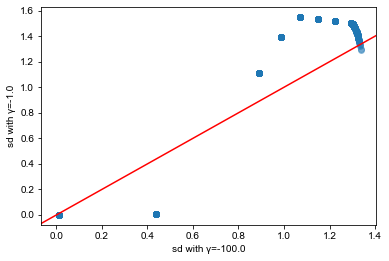

In [114]:
plt.plot(preds_sd,preds_sd2,'o',alpha=0.4)
plt.xlabel('sd with γ={}'.format(trueg1))
plt.ylabel('sd with γ={}'.format(trueg2))
plt.axline((0,0),(1,1),color='red')

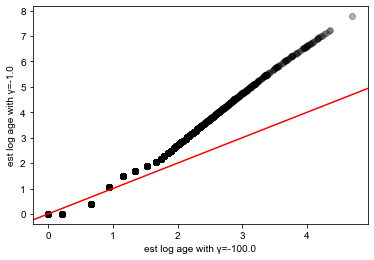

In [160]:
# clear downward bias with gamma=-0.1 (which is what we want - gamma=-100 should not predict high allele ages)
plt.scatter(preds,preds2,alpha=0.3,color='k')
plt.xlabel('est log age with γ={}'.format(trueg1))
plt.ylabel('est log age with γ={}'.format(trueg2))
plt.axline((0,0),(1,1),color='red')

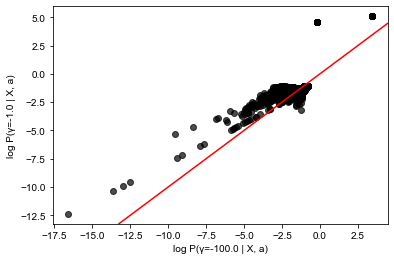

In [161]:
# this trend is good too, since we see that most points are below the 1:1 line indicating that most obs have a higher log prob of being gamma=-0.1
plt.plot(res,res2,'o',alpha=0.7,color='k')
plt.xlabel('log P(γ={} | X, a)'.format(trueg1))
plt.ylabel('log P(γ={} | X, a)'.format(trueg2))
plt.axline((0,0),(1,1),color='red')

In [405]:
## pattern in prediction...
plt.scatter(np.log(newdat[res>=res2,0]),np.log(newdat[res>=res2,2]),color='deepskyblue',alpha=0.6,label='Pred γ={}.'.format(trueg1))
plt.scatter(np.log(newdat[res<res2,0]),np.log(newdat[res<res2,2]),color='coral',alpha=0.6,label='Pred γ={}.'.format(trueg2))
plt.xlabel('log freq')
plt.ylabel('log age')
plt.legend()
plt.grid()

KeyboardInterrupt: 

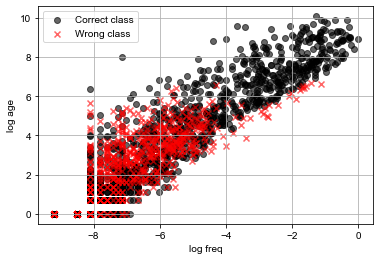

In [233]:
## how much is correctly predicted?
m1 = res>=res2
m2 = np.concatenate((np.full(1000,True), np.full(1000,False)))
mask1 = np.logical_or(np.logical_and(m1, m2), np.logical_and(~m1, ~m2))
mask2 = np.logical_or(np.logical_and(m1, ~m2), np.logical_and(~m1, m2))
plt.scatter(np.log(newdat[mask1,0]),np.log(newdat[mask1,2]),color='k',alpha=0.6,label='Correct class')
plt.scatter(np.log(newdat[mask2,0]),np.log(newdat[mask2,2]),color='red',marker='x',alpha=0.6,label='Wrong class')
plt.xlabel('log freq')
plt.ylabel('log age')
plt.legend()
plt.grid()

In [228]:
print(np.where(np.logical_or(mask,mask2))[0])  
np.where(np.logical_or(~mask,~mask2))[0]

[   2    3    4 ... 1997 1998 1999]


array([   0,    1,    2, ..., 1997, 1998, 1999])

In [221]:
# newdat[res>res2]
# plt.scatter(np.log(newdat[np.logical_or((~mask,~mask2)),0]))

2000

In [244]:
# over 97% of observations fall into the gamma=-0.1 vs gamma=-100. category - which is correct
# ~91% of observations fall into the gamma=-1. vs gamma=-10. category - which is still good
# ~60% accuracy when using gamma=-1. and gamma=-100.
# predicted labels in columns and actual labels in rows (very rarely predict a gamma=-100. when actually gamma=-1.)
np.array([[np.sum(np.logical_and(m1, m2)), np.sum(np.logical_and(m1, ~m2))], [np.sum(np.logical_and(~m1, m2)), np.sum(np.logical_and(~m1,~m2))]])*100/len(mask1)

array([[20.25, 11.1 ],
       [29.75, 38.9 ]])

In [63]:
## check performance of get_lp_alxl as a classifier (create confusion matrix)
totalres = np.empty(len(newdat))
ahat = prob_model(np.vstack((np.log(newdat[:,0]),np.repeat(trueg1,len(newdat[:,0])))).T)
preds = ahat.mean().numpy()
preds_sd = ahat.stddev().numpy()
for ia, a in enumerate(np.log(newdat[:,2])):
    totalres[ia] = scipy.stats.norm.logpdf(a, loc=preds[ia], scale=preds_sd[ia])

In [64]:
totalres2 = np.empty(len(newdat))
ahat2 = prob_model(np.vstack((np.log(newdat[:,0]),np.repeat(trueg2,len(newdat[:,0])))).T)
preds2 = ahat2.mean().numpy()
preds_sd2= ahat2.stddev().numpy()
for ia, a in enumerate(np.log(newdat[:,2])):
    totalres2[ia] = scipy.stats.norm.logpdf(a, loc=preds2[ia], scale=preds_sd2[ia])

In [68]:
# 58.6% accuracy rate (diags), lot more -100. predicted as -0.1, fewer the other way around
# 55.5% accuracy rate (diags), lot more (<2x) -100. predicted as -10., fewer the other way around
# 50.3% accuracy rate (daigs), lot more (>3x) -10. predicted as -1., fewwer the other way around
confusion_matrix(np.array(['A']*1000 + ['B']*1000),np.array(['A' if x==True else 'B' for x in totalres>totalres2]),labels=['A','B'])/2000

array([[0.2975, 0.2025],
       [0.    , 0.    ]])

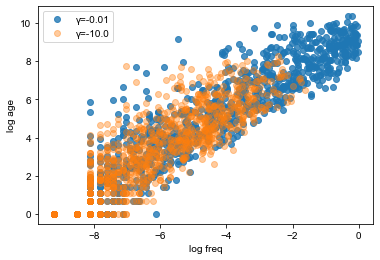

In [406]:
# plotting the ages vs freqs for each selection coefficient
plt.plot(np.log(newdat[0:1000,0]),np.log(newdat[0:1000,2]),'o',label='γ={}'.format(newdat[0,1]),alpha=0.8)
plt.plot(np.log(newdat[1000:2000,0]),np.log(newdat[1000:2000,2]),'o',label='γ={}'.format(newdat[1000,1]),alpha=0.4)
plt.xlabel('log freq')
plt.ylabel('log age')
plt.legend() 

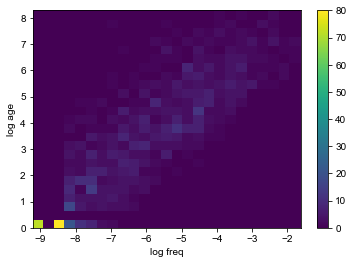

In [152]:
plt.hist2d(np.log(newdat[:,0]),np.log(newdat[:,2]),bins=(25,25))
plt.xlabel('log freq')
plt.ylabel('log age')
plt.colorbar()

In [149]:
trueg1

-1.0

-100.0
CPU times: user 135 ms, sys: 18.2 ms, total: 154 ms
Wall time: 156 ms


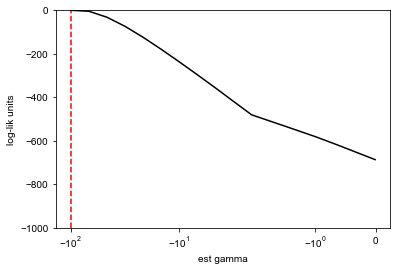

In [80]:
%%time
## assuming only one selection coefficient and only freq info
sin_onlyfreq = np.empty(len(gamma))
for ig, g in enumerate(gamma):
    # sum log prob for each locus
    sin_onlyfreq[ig] = np.sum(get_lp_xl(g, newdat[:,0]))
plt.plot(gamma,sin_onlyfreq-np.max(sin_onlyfreq),'k')
plt.ylim((-1000,0))
plt.xlabel('est gamma')
plt.xscale('symlog')
plt.axvline(gamma[np.argmax(sin_onlyfreq)], color='red', linestyle='--')
plt.ylabel('log-lik units')
print(gamma[np.argmax(sin_onlyfreq)])

In [466]:
## code to check prediction accuracy
preds_sin_onlyfreq = np.zeros(len(gamma))
for ig, g in enumerate(gamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),0:3]
    newdat = newdf1.to_numpy()
    sin_onlyfreq = [np.sum(get_lp_xl(g1, newdat[:,0])) for g1 in gamma]
    preds_sin_onlyfreq[ig] = gamma[np.argmax(sin_onlyfreq)]

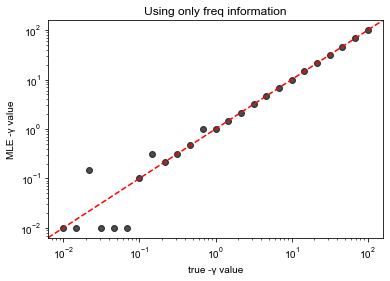

In [481]:
plt.scatter(-gamma, -preds_sin_onlyfreq, color='k', alpha=0.7)
plt.xlabel('true -γ value')
plt.ylabel('MLE -γ value')
plt.yscale('log')
plt.xscale('log')
plt.title('Using only freq information')
plt.axline((100,100),(0,0),color='red',ls='--')

In [81]:
%%time
## assuming two selection coefficients and only freq info (split 50/50)
dub_onlyfreq = np.zeros((len(gamma),len(gamma))) # need a 2d search
for ig1, g1 in enumerate(gamma):
    for ig2, g2 in enumerate(gamma[0:(ig1+1)]):
        dub_onlyfreq[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_xl(g1, newdat[:,0])) + 0.5*np.exp(get_lp_xl(g2, newdat[:,0]))))

CPU times: user 2.88 s, sys: 8.82 ms, total: 2.89 s
Wall time: 2.92 s


In [376]:
mask = np.full(dub_onlyfreq.shape,False)
mask[np.triu_indices_from(dub_onlyfreq,k=1)] = True

array([ -68.12921, -100.     ])

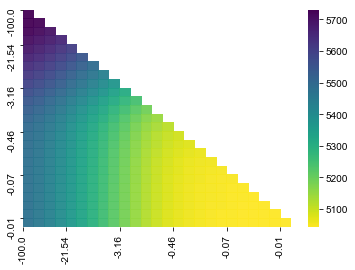

In [83]:
seaborn.heatmap(dub_onlyfreq,alpha=0.95,cmap='viridis_r',mask=mask)
plt.xticks(np.linspace(0,24,6,dtype='int'),gamma[np.linspace(0,24,6,dtype='int')].round(2))
plt.yticks(np.linspace(0,24,6,dtype='int'),gamma[np.linspace(0,24,6,dtype='int')].round(2))
gamma[[np.unravel_index(dub_onlyfreq.argmax(), dub_onlyfreq.shape)]]

In [104]:
## sanity check for predictions one-by-one
print(newdat[90:92,:])
print(get_lp_alxl(-1.,newdat[90:92,0],np.log(newdat[90:92,2])))
get_lp_alxl(-100.,newdat[90:92,0],np.log(newdat[90:92,2]))
# ah = prob_model(np.vstack((np.log(newdat[0,0]),-100.)).T)
# print(ah.mean().numpy())
# print(ah.stddev().numpy())
# scipy.stats.norm.logpdf(0,0.22,0.43)

[[ 4.0e-04 -1.0e+02  5.0e+00]
 [ 6.0e-04 -1.0e+02  1.5e+01]]
[-1.32681003 -1.56206823]


array([-1.13832594, -1.7570332 ])

-10.0
CPU times: user 2.44 s, sys: 20 ms, total: 2.46 s
Wall time: 2.47 s


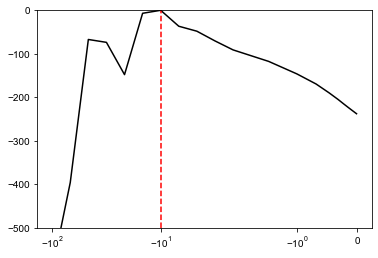

In [84]:
%%time
## assuming only one selection coefficient and both age & freq info
sin_agefreq = np.empty(len(gamma))
for ig, g in enumerate(gamma):
    sin_agefreq[ig] = np.sum(get_lp_alxl(g, newdat[:,0], np.log(newdat[:,2])) + get_lp_xl(g, newdat[:,0]))

plt.plot(gamma,sin_agefreq-np.max(sin_agefreq),'k')
plt.xscale('symlog')
plt.ylim((-500,0))
plt.axvline(gamma[np.argmax(sin_agefreq)], color='red', linestyle='--')
print(gamma[np.argmax(sin_agefreq)])

In [473]:
## code to check prediction accuracy
preds_sin_agefreq = np.zeros(len(gamma))
for ig, g in enumerate(gamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),0:3]
    newdat = newdf1.to_numpy()
    sin_agefreq = [np.sum(get_lp_alxl(g1, newdat[:,0], np.log(newdat[:,2])) + get_lp_xl(g1, newdat[:,0])) for g1 in gamma]
    preds_sin_agefreq[ig] = gamma[np.argmax(sin_agefreq)]

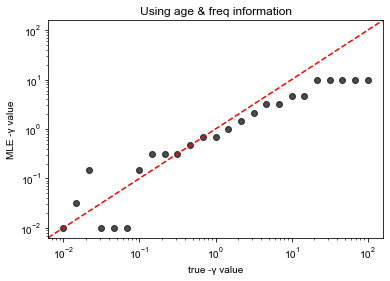

In [479]:
plt.scatter(-gamma, -preds_sin_agefreq, color='k', alpha=0.7)
plt.xlabel('true -γ value')
plt.ylabel('MLE -γ value')
plt.yscale('log')
plt.xscale('log')
plt.title('Using age & freq information')
plt.axline((100,100),(0,0),color='red',ls='--')

In [456]:
## code to check prediction accuracy
preds_sin_onlyage = np.zeros(len(gamma))
for ig, g in enumerate(gamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g)),0:3]
    newdat = newdf1.to_numpy()
    sin_onlyage = [np.sum(get_lp_alxl(g1, newdat[:,0], np.log(newdat[:,2]))) for g1 in gamma]
    preds_sin_onlyage[ig] = gamma[np.argmax(sin_onlyage)]

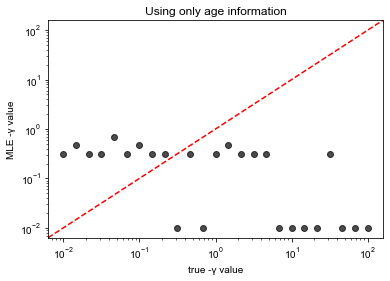

In [482]:
plt.scatter(-gamma, -preds_sin_onlyage, color='k', alpha=0.7)
plt.xlabel('true -γ value')
plt.ylabel('MLE -γ value')
plt.yscale('log')
plt.xscale('log')
plt.title('Using only age information')
plt.axline((100,100),(0,0),color='red',ls='--')

-0.01


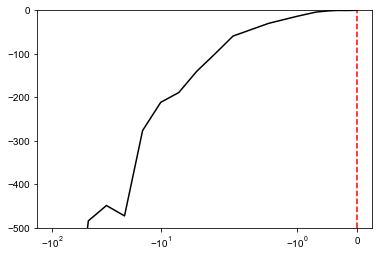

In [85]:
## assuming only one selection coefficient and only age info
sin_onlyage = np.empty(len(gamma))
for ig, g in enumerate(gamma):
    sin_onlyage[ig] = np.sum(get_lp_alxl(g, newdat[:,0], np.log(newdat[:,2])))

plt.plot(gamma,sin_onlyage-np.max(sin_onlyage),'k')
plt.xscale('symlog')
plt.ylim((-500,0))
plt.axvline(gamma[np.argmax(sin_onlyage)], color='red', linestyle='--')
print(gamma[np.argmax(sin_onlyage)])

In [610]:
sin_onlyage

array([-2703.83452552, -2216.85383131, -1573.97879217, -1464.73098629,
       -1470.70363078, -1119.86805864,  -988.82653801,  -936.8260279 ,
        -846.67480332,  -775.5988186 ,  -708.05620585,  -660.68659416,
        -634.00438303,  -617.40223807,  -612.03522642,  -609.92695568,
        -609.70029715,  -609.26389815,  -608.82762248,  -608.49389925,
        -608.26808088,  -608.12512078,  -608.03311327,  -607.97593323,
        -607.93343753])

In [374]:
%%time
## assuming two selection coefficients and only freq info (split 50/50)
dub_agefreq = np.zeros((len(gamma),len(gamma))) # need a 2d search
for ig1, g1 in enumerate(gamma):
    for ig2, g2 in enumerate(gamma[0:(ig1+1)]):
        dub_agefreq[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g1, newdat[:,0], np.log(newdat[:,2])) + get_lp_xl(g1, newdat[:,0])) + 
        0.5*np.exp(get_lp_alxl(g2, newdat[:,0], np.log(newdat[:,2])) + get_lp_xl(g2, newdat[:,0]))))

CPU times: user 2min 3s, sys: 752 ms, total: 2min 4s
Wall time: 2min 6s


In [91]:
np.sum(np.concatenate((get_lp_alxl(trueg1, newdat[0:1000,0], np.log(newdat[0:1000,2])) + get_lp_xl(trueg1, newdat[0:1000,0]), get_lp_alxl(trueg2, newdat[1000:2000,0], np.log(newdat[1000:2000,2])) + get_lp_xl(trueg2, newdat[1000:2000,0])))) 
# ~6744
# dub_agefreq[-1,:]

4698.880973173425

array([ -4.641589, -10.      ])

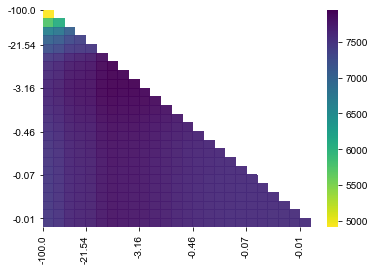

In [377]:
# plt.imshow(dub_agefreq,alpha=0.9,interpolation='none')
# plt.colorbar()
seaborn.heatmap(dub_agefreq,alpha=0.95,xticklabels=gamma,yticklabels=gamma,cmap='viridis_r',mask=mask,norm=matplotlib.colors.Normalize())
plt.xticks(np.linspace(0,24,6,dtype='int'),gamma[np.linspace(0,24,6,dtype='int')].round(2))
plt.yticks(np.linspace(0,24,6,dtype='int'),gamma[np.linspace(0,24,6,dtype='int')].round(2))
gamma[[np.unravel_index(dub_agefreq.argmax(), dub_onlyfreq.shape)]]

In [88]:
%%time
## assuming two selection coefficients and only age info (split 50/50)
# dub_onlyage = np.zeros((len(gamma),len(gamma))) # need a 2d search
# for ig1, g1 in enumerate(gamma):
#     for ig2, g2 in enumerate(gamma[0:(ig1+1)]):
#         dub_onlyage[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g1, newdat[:,0], np.log(newdat[:,2]))) + 
#         0.5*np.exp(get_lp_alxl(g2, newdat[:,0], np.log(newdat[:,2])))))

CPU times: user 1min 1s, sys: 402 ms, total: 1min 1s
Wall time: 1min 3s


In [297]:
# %%time
# dub_onlyage = np.zeros(300)
# for ig, g in enumerate(list(it.combinations(gamma,2))):
    # dub_onlyage[ig] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g[0], newdat[:,0], np.log(newdat[:,2]))) + 0.5*np.exp(get_lp_alxl(g[1], newdat[:,0], np.log(newdat[:,2])))))
## need to transform into a 25x25 array and only fill lower triangle...
# np.reshape(dub_onlyage, (25,25))

ValueError: shape mismatch: value array of shape (300,) could not be broadcast to indexing result of shape (349,)

array([-0.01, -0.01])

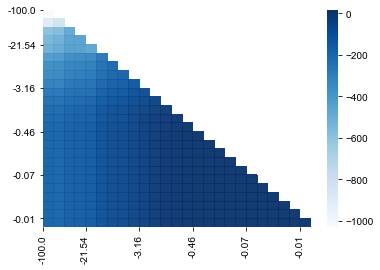

In [89]:
seaborn.heatmap(dub_onlyage,alpha=0.95,xticklabels=gamma,yticklabels=gamma,cmap='Blues',mask=mask)
plt.xticks(np.linspace(0,24,6,dtype='int'),gamma[np.linspace(0,24,6,dtype='int')].round(2))
plt.yticks(np.linspace(0,24,6,dtype='int'),gamma[np.linspace(0,24,6,dtype='int')].round(2))
gamma[[np.unravel_index(dub_onlyage.argmax(), dub_onlyage.shape)]]

In [765]:
# np.full(np.triu(dub_agefreq,k=1),True)
?np.full

Signature: np.full(shape, fill_value, dtype=None, order='C')
Docstring:
Return a new array of given shape and type, filled with `fill_value`.

Parameters
----------
shape : int or sequence of ints
    Shape of the new array, e.g., ``(2, 3)`` or ``2``.
fill_value : scalar or array_like
    Fill value.
dtype : data-type, optional
    The desired data-type for the array  The default, None, means
     `np.array(fill_value).dtype`.
order : {'C', 'F'}, optional
    Whether to store multidimensional data in C- or Fortran-contiguous
    (row- or column-wise) order in memory.

Returns
-------
out : ndarray
    Array of `fill_value` with the given shape, dtype, and order.

See Also
--------
full_like : Return a new array with shape of input filled with value.
empty : Return a new uninitialized array.
ones : Return a new array setting values to one.
zeros : Return a new array setting values to zero.

Examples
--------
>>> np.full((2, 2), np.inf)
array([[inf, inf],
       [inf, inf]])
>>> np.full(

0.0006519192829728129

In [92]:
## get MLE from calculated matrices/vectors
estgonlyfreq = gamma[np.argmax(sin_onlyfreq)]

estgagefreq = gamma[np.argmax(sin_agefreq)]

estg1onlyfreq = gamma[np.unravel_index(dub_onlyfreq.argmax(), dub_onlyfreq.shape)[0]]
estg2onlyfreq = gamma[np.unravel_index(dub_onlyfreq.argmax(), dub_onlyfreq.shape)[1]]

estg1agefreq = gamma[np.unravel_index(dub_agefreq.argmax(), dub_agefreq.shape)[0]]
estg2agefreq = gamma[np.unravel_index(dub_agefreq.argmax(), dub_agefreq.shape)[1]]

estg1onlyage = gamma[np.unravel_index(dub_onlyage.argmax(), dub_onlyage.shape)[0]]
estg2onlyage = gamma[np.unravel_index(dub_onlyage.argmax(), dub_onlyage.shape)[1]]

In [93]:
## get likelihood ratio value
lambfreq = -2.*(dub_onlyfreq[gamma==estg1onlyfreq,gamma==estg2onlyfreq] - sin_onlyfreq[gamma==estgonlyfreq])
print(chi2.sf(lambfreq, 1))

lambagefreq = -2.*(dub_agefreq[gamma==estg1agefreq,gamma==estg2agefreq] - sin_agefreq[gamma==estgagefreq])
print(chi2.sf(lambagefreq, 1))

[1.]
[1.]


In [252]:
print(dub_onlyfreq[gamma==estg1onlyfreq,gamma==estg2onlyfreq])
sin_onlyfreq[gamma==estgonlyfreq]

[5730.36544514]


array([5729.10812555])

In [253]:
print(estgonlyfreq, estgagefreq)
print(estg1onlyfreq, estg2onlyfreq)
# print(estg1agefreq, estg2agefreq)
# print(estg1onlyage, estg2onlyage)

-100.0 -10.0
-68.12921 -100.0


### Template code to compute difference in $\gamma$ given set of data

Here, I will run the mechanism to compute the probability of a significant difference in selection coefficients is detected given a set of large data i.e., 2000 data points and I will resample 25 times to obtain smaller datasets of 500. 

In [254]:
# newdat[np.random.choice(newdat.shape[0], 10, replace=False),:]
chi2.sf(3.84,1)

0.05004352124870519

In [433]:
# num_sims is number of reps to run to calculate prob
# num_samps is number of rows to resample the big data from
# gamma is np.array of values to calculate over
# thresh is threshold to assign significance
def resample_calculateprob_freq(newdat, gamma, num_sims=16, num_samps=500, thresh=0.05):
    prob = 0.
    sin_onlyfreq = np.empty(len(gamma))
    dub_onlyfreq = np.zeros((len(gamma),len(gamma)))
    for n in np.arange(num_sims):
        newnewdat = newdat[np.random.choice(newdat.shape[0], num_samps, replace=False),:]
        for ig, g in enumerate(gamma):
            # sum log prob for each locus
            sin_onlyfreq[ig] = np.sum(get_lp_xl(g, newnewdat[:,0]))
            for ig2, g2 in enumerate(gamma[0:(ig+1)]):
                dub_onlyfreq[ig, ig2] = np.sum(np.log(0.5*np.exp(get_lp_xl(g, newnewdat[:,0])) + 0.5*np.exp(get_lp_xl(g2, newnewdat[:,0]))))

        estgonlyfreq = gamma[np.argmax(sin_onlyfreq)]

        estg1onlyfreq = gamma[np.unravel_index(dub_onlyfreq.argmax(), dub_onlyfreq.shape)[0]]
        estg2onlyfreq = gamma[np.unravel_index(dub_onlyfreq.argmax(), dub_onlyfreq.shape)[1]]

        lambfreq = 2.*(dub_onlyfreq[gamma==estg1onlyfreq,gamma==estg2onlyfreq] - sin_onlyfreq[gamma==estgonlyfreq])

        if(chi2.sf(lambfreq, 1)<thresh):
            prob += 1.

    return prob/num_sims

In [434]:
# num_sims is number of reps to run to calculate prob
# num_samps is number of rows to resample the big data from
# gamma is np.array of values to calculate over
# thresh is threshold to assign significance
def resample_calculateprob_agefreq(newdat, gamma, num_sims=16, num_samps=500, thresh=0.05):
    prob = 0.

    sin_agefreq = np.empty(len(gamma))

    dub_agefreq = np.zeros((len(gamma),len(gamma)))
    for n in np.arange(num_sims):
        newnewdat = newdat[np.random.choice(newdat.shape[0], num_samps, replace=False),:]
        for ig, g in enumerate(gamma):
            # sum log prob for each locus
            sin_agefreq[ig] = np.sum(get_lp_alxl(g, newnewdat[:,0], np.log(newnewdat[:,2])) + get_lp_xl(g, newnewdat[:,0]))
            for ig2, g2 in enumerate(gamma[0:(ig+1)]):
                dub_agefreq[ig, ig2] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g, newnewdat[:,0], np.log(newnewdat[:,2])) + get_lp_xl(g, newnewdat[:,0])) + 0.5*np.exp(get_lp_alxl(g2, newnewdat[:,0], np.log(newnewdat[:,2])) + get_lp_xl(g2, newnewdat[:,0]))))

        estgagefreq = gamma[np.argmax(sin_agefreq)]        

        estg1agefreq = gamma[np.unravel_index(dub_agefreq.argmax(), dub_agefreq.shape)[0]]
        estg2agefreq = gamma[np.unravel_index(dub_agefreq.argmax(), dub_agefreq.shape)[1]]

        lambagefreq = 2.*(dub_agefreq[gamma==estg1agefreq,gamma==estg2agefreq] - sin_agefreq[gamma==estgagefreq])

        if(chi2.sf(lambagefreq, 1)<thresh):
            prob += 1.

    return prob/num_sims

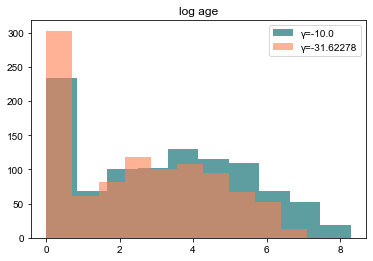

In [484]:
## picking a choice of g1 and g2 & creating a new data frame
trueg1 = -10.0
trueg2 = -31.62278
# 2000 x 3 (first 1000 is g1, second 1000 is g2)
newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==trueg1)),0:3].append(df1.iloc[np.ravel(np.where(dat[:,1]==trueg2)),0:3])
# newdf1 = newdf1.sample(frac=1)
newdat = newdf1.to_numpy()

plt.hist(np.log(newdat[0:1000,2]),color='cadetblue',label='γ={}'.format(trueg1))
plt.title('log age')
plt.hist(np.log(newdat[1000:2000,2]),alpha=0.6,color='coral',label='γ={}'.format(trueg2))
plt.legend()

In [437]:
%%time
resample_calculateprob_agefreq(newdat, gamma, num_sims=16, num_samps=800)

CPU times: user 13min 56s, sys: 5.3 s, total: 14min 2s
Wall time: 14min 16s


0.0

In [443]:
%%time
diffgamma = [(-0.01, x) for x in gamma[:-1]] #list(it.combinations(gamma[0::3], 2))
diffprobs = np.zeros((len(diffgamma),2))
for ig, g in enumerate(diffgamma):
    newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==g[0])),:].append(df1.iloc[np.ravel(np.where(dat[:,1]==g[1])),:])
    # newdf1 = newdf1.sample(frac=1)
    newdat = newdf1.to_numpy()
    diffprobs[ig,0] = resample_calculateprob_freq(newdat, gamma, num_sims=16, num_samps=1000)
    diffprobs[ig,1] = resample_calculateprob_agefreq(newdat, gamma, num_sims=16, num_samps=1000)

CPU times: user 7h 32min 49s, sys: 2min 51s, total: 7h 35min 41s
Wall time: 12h 11min 30s


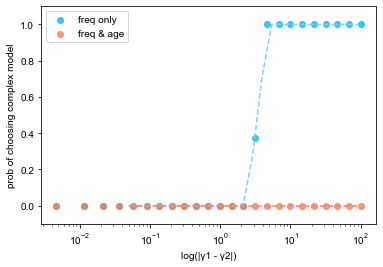

In [485]:
plt.scatter([np.abs(g[1]-g[0]) for g in diffgamma], diffprobs[:,0], color='deepskyblue', alpha=0.8, label='freq only')
plt.scatter([np.abs(g[1]-g[0]) for g in diffgamma], diffprobs[:,1], color='coral', alpha=0.8, label='freq & age')
ginterp = np.logspace(-3,4.5,base=np.exp(1),num=25)
fit = scipy.interpolate.interp1d([np.abs(g[1]-g[0]) for g in diffgamma], diffprobs[:,0], kind='linear')
plt.plot(ginterp, fit(ginterp), '--', color='lightskyblue')
fit = scipy.interpolate.interp1d([np.abs(g[1]-g[0]) for g in diffgamma], diffprobs[:,1], kind='linear')
plt.plot(ginterp, fit(ginterp), '--', color='salmon')
plt.ylim((-0.1,1.1))
plt.xscale('log')
plt.xlabel('log(|γ1 - γ2|)')
plt.ylabel('prob of choosing complex model')
plt.legend()

In [442]:
diffprobs

array([[0., 0.],
       [0., 0.]])

In [432]:
[(-0.01, x) for x in gamma[-3:-1]]

[(-0.01, -0.02154435), (-0.01, -0.01467799)]

In [429]:
# np.savetxt('age_freq_diffprobs.txt', diffprobs, comments='# diffgamma = list(it.combinations(gamma[0::3], 2))')

### Detective work to check accuracy of NN 

Below, I will test the prediction accuracy of the neural net, for certain combinations of frequency and $\gamma$...  
As per Jeremy's suggestion, plotting a pdf of the $P(\log a_l | X_l, \gamma=-0.01, -100.)$ and a histogram of observed ages on top of it (?)